In [6]:
!pip install scikit-learn

     |████████████████████████████████| 7.2 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 8.1 MB/s eta 0:00:01


In [8]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import copy
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Runnning on {device}')

transform = transforms.ToTensor()

train_dset = torchvision.datasets.MNIST('../', train=True, transform=transform, target_transform=None, download=False)
test_dset = torchvision.datasets.MNIST('../', train=False, transform=transform, target_transform=None, download=False)

train_dl = torch.utils.data.DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=1) 


Runnning on cpu


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.reshape(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

net = Net()
net.to(device)
net(torch.rand(40,1,28,28).to(device)).shape 

torch.Size([40, 10])

In [11]:
class ClassifierCNN:
  # CNN to classify images
    def __init__(self,train_dataloader,test_dataloader,model):
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        print(f'Runnning on {self.device}')
        self.train_stats = {
                          "epoch":[],
                          "batch":[],
                          "train_loss":[],
                          "train_acc":[],
                          "test_loss":[],
                          "test_acc":[]
                          }

    
    def batch_acc_loss(self,dataloader):
        # take a batch from dataloader and compute accuracy and loss
        inputs,labels = next(iter(dataloader))
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        outputs = self.model(inputs)
        preds = torch.argmax(outputs,1)

        if len(preds) == len(labels):
            acc = torch.sum((preds == labels)*1.).item()/len(preds)

        loss = self.criterion(outputs,labels).item()
        return acc,loss
      
    def train(self, lr = 1e-3,epochs=10,metrics_interval=10):
          
          self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
          
          for epoch in tqdm(range(epochs)):
              for i, (inputs,labels) in enumerate(self.train_dataloader):
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  
                  # Training 
                  self.model.train()
                  self.optimizer.zero_grad()
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs,labels)
                  loss.backward()
                  self.optimizer.step()

                  # Eval mode
                  self.model.eval()
                  if i% metrics_interval == 0:
                      with torch.no_grad():
                          
                          train_acc, train_loss = self.batch_acc_loss(self.train_dataloader)
                          val_acc, val_loss = self.batch_acc_loss(self.test_dataloader)
                          
                          self.train_stats['epoch'].append(epoch)
                          self.train_stats['batch'].append(i)
                          self.train_stats['train_loss'].append(train_loss)
                          self.train_stats['train_acc'].append(train_acc)
                          self.train_stats['test_loss'].append(val_loss)
                          self.train_stats['test_acc'].append(val_acc)

    def lr_find(self, start = 1e-10, stop = 1):
        model = copy.deepcopy(self.model)
        lr_data = {'lr':[],'loss':[]}
        steps = len(self.train_dataloader)
        optimizer = optim.SGD(model.parameters(), lr=start, momentum=0.9)
        mult = np.exp(np.log(stop/start)/steps) # multiplicative exponent   
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: mult)
        
        for i,(inputs, labels) in enumerate(self.train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.train() 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = self.criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            lr_data['loss'].append(loss.item())   
            for param_group in optimizer.param_groups:
                lr_data['lr'].append(param_group['lr'])
                
            scheduler.step()

        df = pd.DataFrame(lr_data)
        plt.semilogx(df['lr'],df['loss'])
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.show()
        return df

    def tensor_to_PIL(self,x):    
        to_pil = torchvision.transforms.ToPILImage()
        img = to_pil(x)
        return img

    def test(self):
        with torch.no_grad():
            test_stats = {'label':[],'pred':[],'loss':[],'input':[]}
            for (xb,yb) in tqdm(self.test_dataloader):
                for i in range(len(xb)):
                    x = xb[i].unsqueeze(0)
                    y = torch.tensor([yb[i]])
                    x = x.to(device)
                    y = y.to(device)
                    self.model.to(device)

                    output = self.model(x)
                    loss = self.criterion(output,y)
                    pred = torch.argmax(output,1)

                    test_stats['label'].append(y.item())
                    test_stats['pred'].append(pred.item())
                    test_stats['loss'].append(loss.item())
                    test_stats['input'].append(self.tensor_to_PIL(x[0].cpu()))

            self.test_stats = pd.DataFrame(test_stats).sort_values(by=['loss'],ascending=False)

    def view_train_stats(self):
        plt.title('Training vs Testing loss')
        plt.plot(self.train_stats['train_loss'],label = 'training loss')
        plt.plot(self.train_stats['test_loss'],label = 'test loss')
        plt.legend()
        plt.show()
        plt.title('Training vs Testing accurcy')
        plt.plot(self.train_stats['train_acc'],label = 'training accuracy')
        plt.plot(self.train_stats['test_acc'],label = 'test accuracy')
        plt.legend()
        plt.show()

    
    def view_top_losses(self,num = 5):
        plt.figure(figsize=(20,5))
        for i in range(num):
            plt.subplot(1,num,i+1)
            label,pred,loss,inpt = self.test_stats.iloc[i]
            plt.imshow(inpt,cmap='gray_r')
            plt.title(f"Label:{label},pred:{pred},loss:{round(loss,2)}")
        plt.tight_layout()
        plt.show()

    def view_confusion_matrix(self):
        classes = np.unique(self.test_stats['label'])
        df_cm = pd.DataFrame(confusion_matrix(self.test_stats['label'], self.test_stats['pred']), classes, classes)
        sn.set(font_scale=1.4) # for label size
        plt.figure(figsize=(20,12))
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap="YlGnBu") # font size
        plt.xlabel('Predicted class')
        plt.ylabel('True class')
        plt.show()

Runnning on cpu


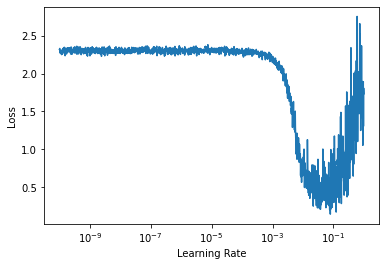

100%|██████████| 1/1 [03:15<00:00, 195.12s/it]


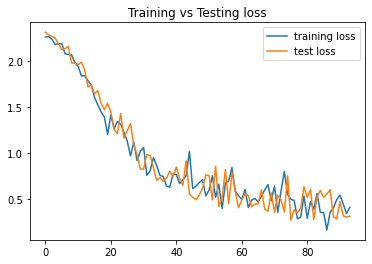

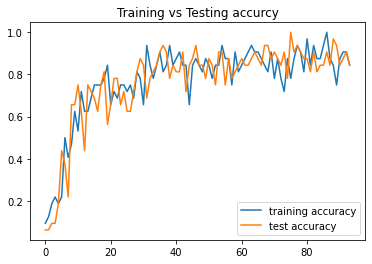

100%|██████████| 313/313 [00:04<00:00, 73.44it/s]


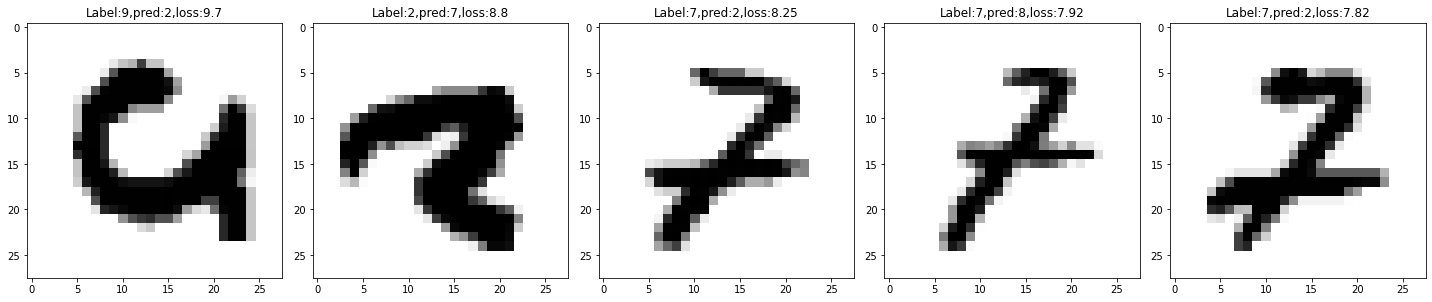

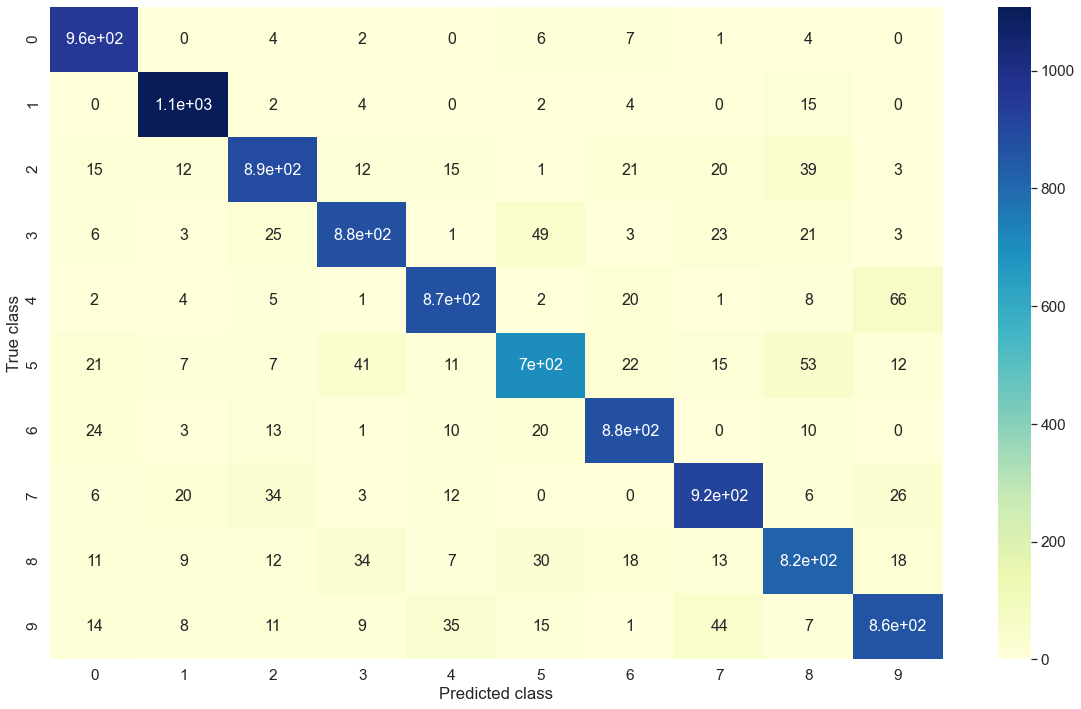

In [12]:
cnn = ClassifierCNN(train_dl,test_dl,net)
cnn.lr_find()
cnn.train(lr=1e-3,epochs=1,metrics_interval=20)
cnn.view_train_stats()
cnn.test()
cnn.view_top_losses()
cnn.view_confusion_matrix()